In [1]:
# initialize accelerator and trackers (if enabled)
from os import makedirs,path,scandir
import pickle
import cv2
import json
from yacs.config import CfgNode as CN
from torch.utils.data import Dataset
from tqdm import tqdm
import logging
import random
import torch
# from src.datasets import FFPP,RPPG
from accelerate import Accelerator
from main import get_config,init_accelerator,set_seed,FFPP
logging.basicConfig(level="DEBUG")

class Obj:
    pass
c = FFPP.get_default_config()
c.augmentation = "normal+frame"
accelerator =  Accelerator(mixed_precision='no')
x = FFPP(c,10,2,lambda x: x,accelerator,split="train")
c


/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 5/5 [00:00<00:00, 1542.93it/s]

CfgNode({'category': 'train', 'root_dir': './datasets/ffpp/', 'detection_level': 'video', 'types': ['REAL', 'DF', 'F2F', 'FS', 'NT'], 'compressions': ['raw'], 'name': 'FFPP', 'scale': 1.0, 'pack': 0, 'pair': 0, 'contrast': 0, 'augmentation': ['normal', 'frame']})

In [2]:
typ,cmp,idx,_ = x.video_list[1]
x.video_table[typ][cmp][idx]


{'fps': 30,
 'frames': 368,
 'duration': 12.266666666666667,
 'path': './datasets/ffpp/real/raw/videos/054.avi'}

In [3]:
len(x)

29212

In [9]:
frames,label,mask,_,_ = x[10]
(len(frames),label,len(mask))

DEBUG:root:Item/Video Index:10/1
DEBUG:root:Item DF/COMP:REAL/raw
DEBUG:root:Video Speed Motion Factor: 0.5708270883747822
DEBUG:root:Video Shift Factor: 0.007013081174125739
DEBUG:root:Loading Video: ./datasets/ffpp/real/raw/videos/054.avi
DEBUG:root:Sample Offset: 6
DEBUG:root:Sample Stride: 0.12222222222222222


(1, 0, 10)

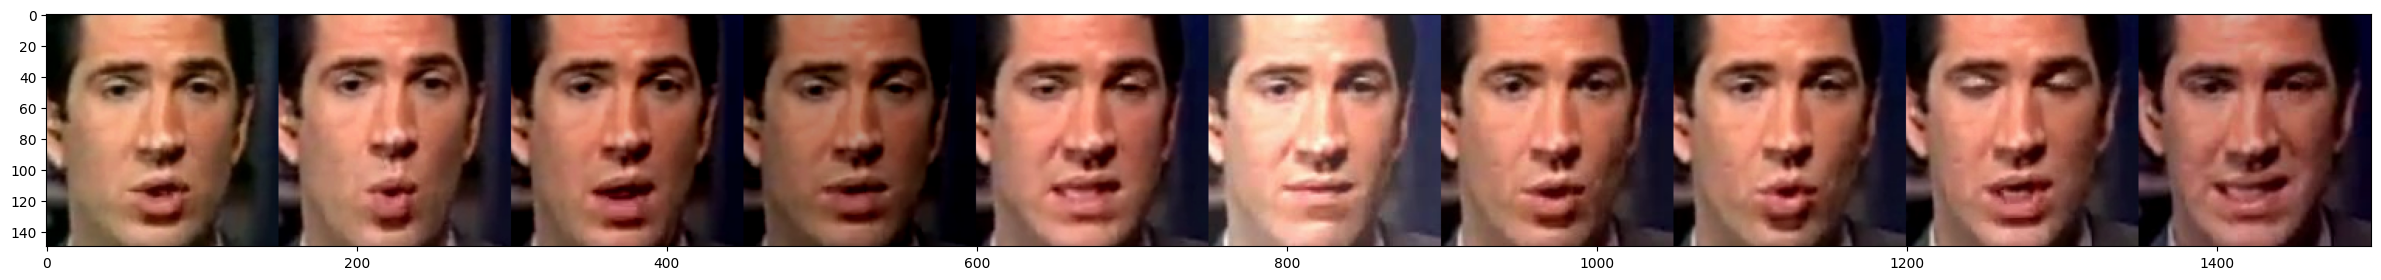

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(30,150))
plt.imshow(np.stack(frames["raw"][:30].numpy().transpose((0,2,3,1)),axis=1).reshape((150,-1,3)))

In [ ]:
for i in tqdm(range(len(x))):
    try:
        x[i]
    except Exception as e:
        print(f"Error Occur at {i}:{e}")
